## 1. Pré-processamento

O *dataset* original consistia em uma série temporal com **2.356.110 instâncias** e seis colunas principais (`date`, `state`, `name`, `code`, `cases`, `deaths`). Para atender aos objetivos de **aprendizado não supervisionado**, foi necessário transformar esses dados brutos em uma representação **descritiva e consolidada por município**.

#### Limpeza e Agregação dos Dados

Como cada município aparecia repetidamente ao longo do tempo, realizamos etapas de agregação para sintetizar seu perfil epidemiológico:

- **Tratamento dos dados:** remoção de valores nulos, registros em branco e colunas irrelevantes para a análise de *clusters*.
- **Engenharia de atributos (*feature engineering*):**
  - `total_cases`: total acumulado de casos por município.
  - `peak_cases`: maior número de casos registrados em um único dia, representando a intensidade do pico pandêmico local.

Essas transformações permitiram capturar tanto a magnitude quanto a dinâmica da disseminação da doença em cada localidade.

### Preparação para os Algoritmos de *Machine Learning*

Considerando que os algoritmos de *Machine Learning* operam exclusivamente sobre dados numéricos e são sensíveis à escala das variáveis, aplicamos as seguintes técnicas:

- **One-Hot Encoding:** conversão de variáveis categóricas em representações numéricas, possibilitando o seu uso nos modelos.
- **Normalização (`StandardScaler`):** padronização das variáveis numéricas.

#### &emsp; 1.1 Baixando o dataset

In [ ]:
# Intalação do gdown para pegar .csv bruto
%pip install gdown

In [ ]:
# Baixar o .csv bruto
import os.path as path
if not path.exists('./data/brazil_covid19_cities.csv'):
  print("Baixando arquivo...")
  !gdown "1sg9QK4g8QKCNgvfi6iNowcP75KNNkxUY" -O ./data/brazil_covid19_cities.csv

In [ ]:
# Importação do csv
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
from sklearn.metrics import silhouette_score
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.neighbors import NearestNeighbors
import numpy as np
import umap
df = pd.read_csv('./data/brazil_covid19_cities.csv')

#### &emsp; 1.2 Modelando os dados 

In [ ]:
# Renomear coluna name para city
df = df.rename(columns={'name': 'city'})

In [ ]:
# Transforma a coluna `date` em um objeto DateTime
df['date'] = pd.to_datetime(df['date'])
df = df.sort_values(['city', 'date'])

In [ ]:
# Garantir que casos e mortes são numéricos
df['cases'] = pd.to_numeric(df['cases'], errors='coerce')
df['deaths'] = pd.to_numeric(df['deaths'], errors='coerce')

df = df.dropna(subset=['city', 'cases', 'deaths'])

In [ ]:
# Adição de variáveis por cidade e estado
features_city = df.groupby(['city', 'state']).agg({
  'cases': ['max', 'mean', 'std'],
  'deaths': ['max', 'mean', 'std'],
  'date': 'count'
})

features_city.columns = [
  'total_cases',
  'mean_cases',
  'std_cases',
  'total_deaths',
  'mean_deaths',
  'std_deaths',
  'days_recorded'
]

features_city.head()

In [ ]:
# Adição de coluna `death_rate` (taxa de mortalidade)
features_city['death_rate'] = (
    features_city['total_deaths'] / features_city['total_cases']
)


In [ ]:
# Crescimento dos casos
df['new_cases'] = df.groupby(['city', 'state'])['cases'].diff().fillna(0)

growth = df.groupby(['city', 'state'])['new_cases'].mean().rename('mean_daily_growth')
features_city = features_city.join(growth)

In [ ]:
# Dia do primeiro caso
first_case = df[df['cases'] > 0].groupby(['city','state'])['date'].min()
first_case = (first_case - df['date'].min()).dt.days
first_case = first_case.rename('days_until_first_case')

features_city = features_city.join(first_case)

In [ ]:
# Remoção de registros com dados faltosos
features_city = features_city.dropna()

In [ ]:
# Reset de índices
features_city = features_city.reset_index()

In [ ]:
# Remoção do do campo `city`
features_city.drop('city', axis=1, inplace=True)

In [ ]:
# Aplicando one-hot encode no campo `state`
features_city = pd.get_dummies(features_city, columns=['state'])

In [ ]:
# Finalização do DataFrame tratado
df = features_city.copy()

In [ ]:
df.info()

## Estruturação dos Dados pós-processamento

Após as etapas de limpeza, o conjunto de dados consolidado passou a contar com 5.570 instâncias. Isso representa a totalidade dos municípios brasileiros e 37 colunas estruturadas.

| Categoria                          | Métrica / Atributo           | Descrição                                                                 |
|-----------------------------------|------------------------------|---------------------------------------------------------------------------|
| **Magnitude e Dispersão**          | `total_cases`                | Total acumulado de casos por município.                                   |
|                                   | `mean_cases`                 | Média diária de casos registrados ao longo do período analisado.          |
|                                   | `std_cases`                  | Desvio padrão dos casos diários, indicando a variabilidade do contágio.   |
|                                   | `total_deaths`               | Total acumulado de óbitos por município.                                  |
|                                   | `mean_deaths`                | Média diária de óbitos registrados no período.                             |
| **Indicadores Epidemiológicos**    | `death_rate`                 | Taxa de letalidade por município (óbitos / casos confirmados).            |
| **Avançados**                     | `mean_daily_growth`          | Velocidade média de crescimento diário dos casos.                          |
|                                   | `days_until_first_case`      | Número de dias até o registro do primeiro caso no município.               |
| **Localização Geográfica**         | `state_AC` – `state_TO`      | Variáveis binárias geradas por One-Hot Encoding para representar os estados |
|                                   |                              | brasileiros, permitindo capturar regionalidade sem ordem numérica.        |


## Normalização

In [ ]:
# Normalização
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df)

## 2. Redução de Dimensionalidade


In [ ]:
df_reduc = dict()    # Objeto pra agupar os resultados dos métodos

#### &emsp; 2.1 Aplicação de PCA

In [ ]:
# Inicializando a PCA
pca_full = PCA()
pca_full.fit(df_scaled)

pca = PCA(n_components=2)
df_scaled_pca = pca.fit_transform(df_scaled)

# Adiciona o resultado ao conjunto de resultados
df_reduc['pca'] = df_scaled_pca

# Calculando a variancia explicada acumulada
variancia_acumulada = np.cumsum(pca_full.explained_variance_ratio_)

In [ ]:
# Criando a moldura com 1 linha e 2 colunas
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7))

# Visualização PCA
ax1.scatter(df_scaled_pca[:, 0], df_scaled_pca[:, 1], alpha=0.6, edgecolors='w', s=40)
ax1.set_title('Visualização PCA (n_components=2)', fontsize=14)
ax1.set_xlabel('Primeiro Componente Principal (PC1)')
ax1.set_ylabel('Segundo Componente Principal (PC2)')
ax1.grid(True, linestyle='--', alpha=0.6)

# Vizualização da Variância
ax2.plot(range(1, len(variancia_acumulada) + 1), variancia_acumulada, marker='o', linestyle='--')
ax2.axhline(y=0.80, color='r', linestyle='-', label='Corte de 80%') # Linha de corte
ax2.set_title('Variância Explicada Acumulada', fontsize=14)
ax2.set_xlabel('Número de Componentes')
ax2.set_ylabel('Variância Coberta (0 a 1.0)')
ax2.legend()
ax2.grid(True, linestyle='--', alpha=0.6)

# Ajustando o layout para não sobrepor
plt.tight_layout()
plt.show()

# Print informativo
print(f"Variância Total com 2 componentes: {variancia_acumulada[1]:.2%}")

#### &emsp;  2.2 Aplicação de t-SNE

In [ ]:
# Definindo as preplexidades para teste
perplexidades = [20, 30, 50]

In [ ]:
# Criando muldura para as imagnes
fig, axes = plt.subplots(1, 3, figsize=(22, 7))

# Adiciona o resultado ao conjunto de resultados
df_reduc['tsne'] = dict()

for i, perp in enumerate(perplexidades):
    # Aplicando o t-SNE (usamos random_state para resultados reproduzíveis)
    tsne = TSNE(n_components=2, perplexity=perp, max_iter=1000, learning_rate=200, random_state=42)
    df_tsne = tsne.fit_transform(df_scaled)

    df_reduc['tsne'][perp] = df_tsne

    # Plotando no subplot correspondente (axes[i])
    axes[i].scatter(df_tsne[:, 0], df_tsne[:, 1], alpha=0.6, s=20)
    axes[i].set_title(f't-SNE (Perplexity={perp})', fontsize=14)
    axes[i].set_xlabel('Componente t-SNE 1')
    axes[i].set_ylabel('Componente t-SNE 2')
    axes[i].grid(True, linestyle='--', alpha=0.5)

# Ajusta o espaçamento para os títulos não cortarem
plt.tight_layout()
plt.show()

#### &emsp;  2.3 Aplicação de UMAP

In [ ]:
vizinhos = [15, 30, 100]
df_reduc['umap'] = dict()

fig, axes = plt.subplots(1, 3, figsize=(22, 7))

for i, n in enumerate(vizinhos):
    # Aplicando o UMAP
    reducer = umap.UMAP(n_neighbors=n, min_dist=0.1, random_state=42)
    df_umap = reducer.fit_transform(df_scaled)

    # Adiciona o resultado ao conjunto de resultados
    df_reduc['umap'][n] = df_umap

    # Plotando no subplot correspondente
    scatter = axes[i].scatter(df_umap[:, 0], df_umap[:, 1], alpha=0.6, s=15, cmap='viridis')
    axes[i].set_title(f'UMAP (n_neighbors={n})', fontsize=14)
    axes[i].set_xlabel('UMAP 1')
    axes[i].set_ylabel('UMAP 2')
    axes[i].grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.suptitle('Efeito do Parâmetro n_neighbors no UMAP', fontsize=16, y=1.05)
plt.show()

## 3. Clusterização

### &emsp;  3.1 Aplicação de K-Means

In [ ]:
df_kmeans_t = df_reduc['tsne'][50]   # <-- Placeholder, liga o df usado a um dos outputs (PCA/t-SNE/UMAP)
df_kmeans_u = df_reduc['umap'][30]

#### 3.1.1 Método do cotovelo

In [ ]:
k_range = range(1, 11)
inertias = []
clustering_results = []

for k in k_range:
  model = KMeans(n_clusters=k, max_iter=150, random_state=42)
  model.fit(df_kmeans)

  current_inertia = 0
  for i in range(k):
    cluster_points = df_kmeans[model.labels_ == i]
    current_inertia += np.sum((cluster_points - model.cluster_centers_[i])**2)

  inertias.append(current_inertia)
  clustering_results.append({'labels': model.labels_, 'centroids': model.cluster_centers_})

plt.figure(figsize=(10, 6))
plt.plot(k_range, inertias, 'bo-')
plt.xlabel('Número de Clusters (K)')
plt.ylabel('Inércia (WGSS)')
plt.title('Método do Cotovelo para Encontrar o K Ótimo')
plt.xticks(k_range)
plt.grid(True)

# Marcar o ponto escolhido (k=4) no gráfico
k_target = 4
if k_target in k_range:
    y_target = inertias[k_target - 1]
    plt.scatter(k_target, y_target, marker='*', color='red', s=200, zorder=5, label='k=4: valor ótimo')
    plt.legend()
plt.show()

In [ ]:
# Aplicação do k-means com k=4 e redução com t-SNE
kmeans = KMeans(n_clusters=4, max_iter=500, random_state=42)
kmeans.fit(df_kmeans_t)
kmeans_labels_t = kmeans.labels_

In [ ]:
# Aplicação do k-means com k=4 e redução com UMAP
kmeans = KMeans(n_clusters=4, max_iter=500, random_state=42)
kmeans.fit(df_kmeans_u)
kmeans_labels_u = kmeans.labels_

In [ ]:
fig, axes = plt.subplots(1,2, figsize=(16,7))

# Plot 1: Agrupamento do k-means
axes[0].scatter(df_kmeans_t[:, 0], df_kmeans_t[:, 1], c=kmeans_labels_t, s=50, cmap='viridis', edgecolor='k')
axes[0].set_title("Clusters encontrados pelo k-means (t-SNE)")
axes[0].set_xlabel('Componente 1')
axes[0].set_ylabel('Componente 2')
axes[0].grid(True)

# Plot 2: Classes reais do dataset
scatter = axes[1].scatter(df_kmeans_u[:, 0], df_kmeans_u[:, 1], c=kmeans_labels_u, s=50, cmap='viridis', edgecolor='k')
axes[1].set_title("Clusters encontrados peo k-means (UMAP)")
axes[1].set_xlabel('Componente 1')
axes[1].set_ylabel('Componente 2')
axes[1].grid(True)

In [ ]:
# # Visualização do k-means
# plt.figure(figsize=(10,6))

# # Plotar cada cluster separadamente para criar legenda clara
# unique_labels = np.unique(kmeans_labels)
# cmap = plt.get_cmap('viridis', len(unique_labels))
# for i, label in enumerate(unique_labels):
#   mask = kmeans_labels == label
#   plt.scatter(df_kmeans[mask, 0], df_kmeans[mask, 1], s=50, color=cmap(i), edgecolor='k', label=f'Cluster {int(label)}')

# # Criação do gráfico
# plt.title('Resultado da clusterização com K-means (k=4)')
# plt.xlabel('Componente 1')
# plt.ylabel('Componente 2')
# plt.grid(True)
# plt.legend(loc='upper right', title='Clusters')
# plt.show()

### &emsp;  3.2 Aplicação de DBSCAN

In [105]:
df_dbscan_t = df_reduc['tsne'][50]
df_dbscan_u = df_reduc['umap'][30]

In [ ]:
fig, axes = plt.subplots(1,2, figsize=(16,7))

# Plot 1: Agrupamento do k-means
axes[0].scatter(df_kmeans_t[:, 0], df_kmeans_t[:, 1], c=kmeans_labels_t, s=50, cmap='viridis', edgecolor='k')
axes[0].set_title("Clusters encontrados pelo k-means (t-SNE)")
axes[0].set_xlabel('Componente 1')
axes[0].set_ylabel('Componente 2')
axes[0].grid(True)

# Plot 2: Classes reais do dataset
scatter = axes[1].scatter(df_kmeans_u[:, 0], df_kmeans_u[:, 1], c=kmeans_labels_u, s=50, cmap='viridis', edgecolor='k')
axes[1].set_title("Clusters encontrados peo k-means (UMAP)")
axes[1].set_xlabel('Componente 1')
axes[1].set_ylabel('Componente 2')
axes[1].grid(True)

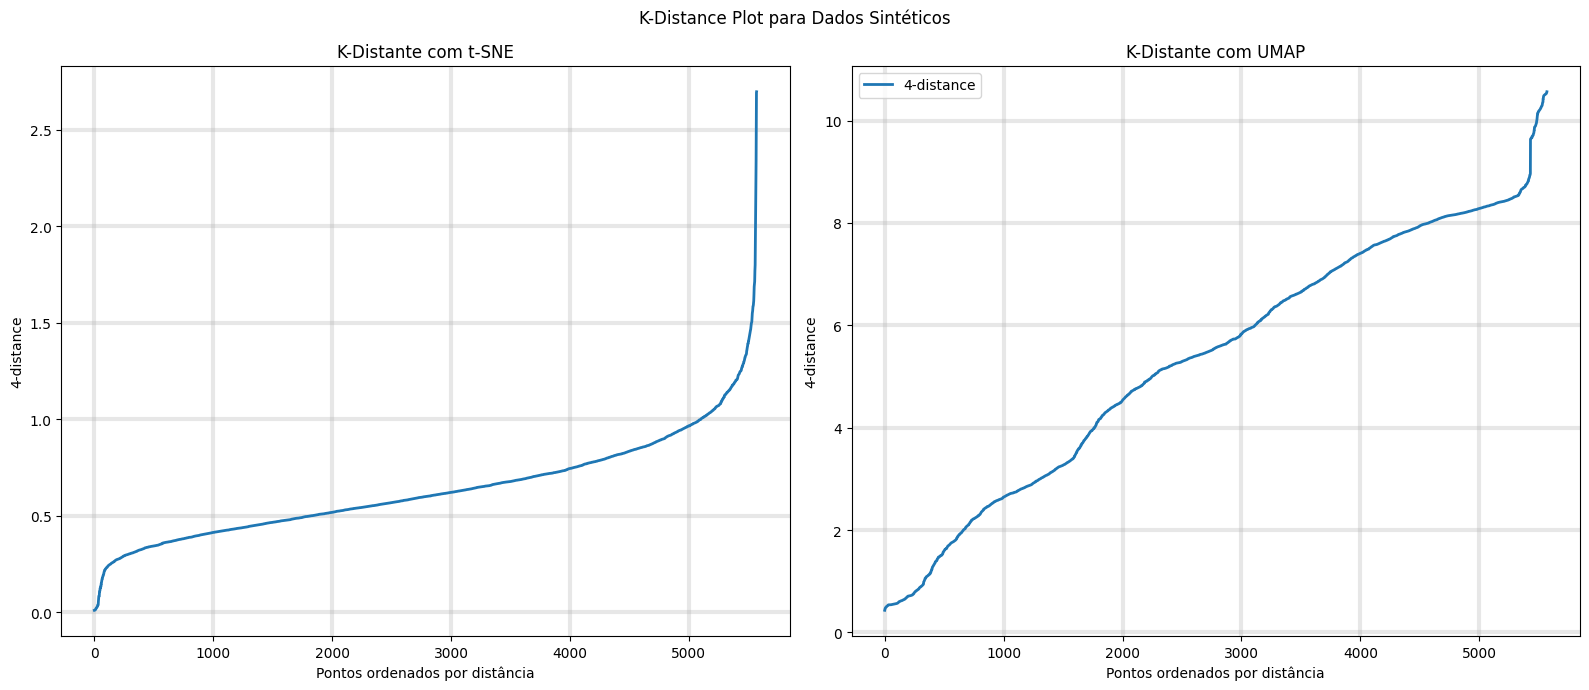

In [114]:
min_pts = 5

fig, axes = plt.subplots(1,2, figsize=(16,7))
k = int(min_pts - 1)

# Plot do primeiro gráfico
nn_t = NearestNeighbors(n_neighbors=k+1, metric="euclidean")
nn_t.fit(df_dbscan_t)
distances, _ = nn_t.kneighbors(df_dbscan_t)
kth_distances = distances[:, k]
k_distances_sorted = np.sort(kth_distances)

axes[0].plot(range(len(k_distances_sorted)), k_distances_sorted, linewidth=2,
          label=f'{k}-distance')
axes[0].set_xlabel("Pontos ordenados por distância")
axes[0].set_ylabel(f"{k}-distance")
axes[0].set_title('K-Distante com t-SNE')

# Plot do segundo gráfico
nn_u = NearestNeighbors(n_neighbors=k+1, metric="euclidean")
nn_u.fit(df_dbscan_u)
distances, _ = nn_t.kneighbors(df_dbscan_u)
kth_distances = distances[:, k]
k_distances_sorted = np.sort(kth_distances)

axes[1].plot(range(len(k_distances_sorted)), k_distances_sorted, linewidth=2,
          label=f'{k}-distance')
axes[1].set_xlabel("Pontos ordenados por distância")
axes[1].set_ylabel(f"{k}-distance")
axes[1].set_title('K-Distante com UMAP')

plt.suptitle('K-Distance Plot para Dados Sintéticos')
axes[0].grid(True, alpha=0.3, linewidth=3.0)
axes[1].grid(True, alpha=0.3, linewidth=3.0)
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
# def plot_k_distance(X, min_pts, title="K-Distance Plot"):
#   k = int(min_pts - 1)

#   nn = NearestNeighbors(n_neighbors=k+1, metric="euclidean")
#   nn.fit(X)
#   distances, _ = nn.kneighbors(X)
#   kth_distances = distances[:, k]
#   k_distances_sorted = np.sort(kth_distances)
#   # Plot
#   plt.figure(figsize=(10, 6))
#   plt.plot(range(len(k_distances_sorted)), k_distances_sorted, linewidth=2,
#             label=f'{k}-distance')
#   plt.xlabel("Pontos ordenados por distância")
#   plt.ylabel(f"{k}-distance")
#   plt.title(title)
#   plt.grid(True, alpha=0.3, linewidth=3.0)
#   plt.legend()
#   plt.tight_layout()
#   plt.show()

In [ ]:
# plot_k_distance(df_dbscan, min_pts=5, title="K-Distance Plot para Dados Sintéticos (t-SNE)")

## 4. Discussão de resultados